# Integrating eccentric Comets with MERCURIUS
In this example, we study highly eccentric comets which interact with a Neptune mass planet.

MERCURIUS is a hybrid integration scheme which combines the WHFAST and IAS15 algorithms. It smoothly transitions between the two integrators, similar to what the hybrid integrator in the MERCURY package is doing. 

In [1]:
import rebound
import numpy as np

First let's choose the basic properties required for the MERCURIUS integrator to run correctly. In particular, we are:  
* adding comets as *semi-active* bodies, which means they can influence/be influenced by other active bodies, but are invisible to each other. This is done by setting `testparticle_type = 1`. Setting `testparticle_type = 0` would indicate that we are adding comets as *test* bodies.
* merging bodies when a collision is triggered, conserving momentum and mass.
* removing particles that leave our pre-defined box.
* tracking the energy lost due to ejections or collisions.

In [2]:
sim = rebound.Simulation()
np.random.seed(42)

#integrator options
sim.integrator = "mercurius"
sim.dt = 1
sim.testparticle_type = 1

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.boundary = "open"
boxsize = 200.
sim.configure_box(boxsize)
sim.track_energy_offset = 1

#simulation time
tmax = 1e4

Now that the preliminary setup is complete, it's time to add some particles to the system! When using the MERCURIUS integrator it is important to add active bodies first and semi-active bodies later. The `sim.N_active` variable distinguishes massive bodies from semi-active/test bodies.

In [3]:
#massive bodies
sim.add(m=1., r=0.005)                     # Sun
a_neptune = 30.05
sim.add(m=5e-5,r=2e-4,a=a_neptune,e=0.01)  # Neptune

sim.N_active = sim.N

Now, let's create some comets! For this simple example we are assuming that all comets have the same mass and radius.

In [4]:
# semi-active bodies
n_comets = 100
a = np.random.random(n_comets)*10 + a_neptune
e = np.random.random(n_comets)*0.009 + 0.99
inc = np.random.random(n_comets)*np.pi/2.
m = 1e-10
r = 1e-7

for i in xrange(0,n_comets):
    rand = np.random.random()*2*np.pi
    sim.add(m=m, r=r, a=a[i], e=e[i], inc=inc[i], Omega=0, omega=rand, f=rand)

We need to move to the COM frame to avoid drifting out of our simulation box. Also, it is always good practice to monitor the change in energy over the course of a simulation, which requires us to calculate it before and after the simulation.

In [5]:
sim.move_to_com()
E0 = sim.energy()

We can visualize our setup using `rebound.OrbitPlot`

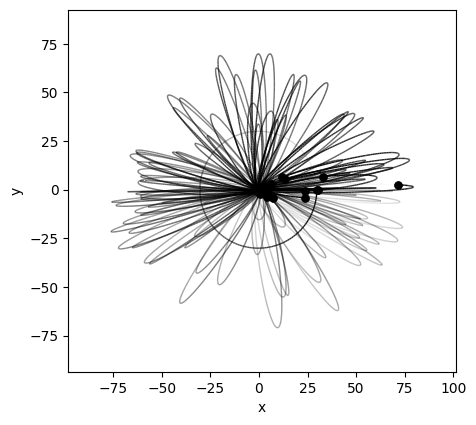

In [6]:
%matplotlib inline
op = rebound.OrbitPlot(sim,Narc=300)

Finally, let's simulate our system for and check that our final relative energy error is small. The energy error is a key measure of whether the integration was performed accurately or not.

In [8]:
sim.integrate(tmax)
dE = abs((sim.energy() - E0)/E0)
print(dE)

2.5543044854706415e-06
